In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from time import time
from PINN.European import EuropeanPINN
from PINN.utilities import V_BS, V_BS_CN

import warnings
warnings.filterwarnings("ignore")

BS PDE
$$
\frac{\partial V}{\partial \tau}-\frac{\sigma^2 S^2}{2} \frac{\partial^2 V}{\partial S^2}-r S \frac{\partial V}{\partial S}+r V=0.
$$

For European put option, we have initial and boundary conditions
$$
V(S, 0) = (K - S)^+, V(0, \tau) = Ke^{-r\tau}, V(\infty, \tau) = 0.
$$

For European options, we have analytic solutions
$$
V(S, \tau)=K e^{-r \tau}\left(1-N\left(d_2\right)\right)+\left(N\left(d_1\right)-1\right) S,
$$
where
$$
d_1=\frac{\log (S / K)+\left(r+0.5 \sigma^2\right) \tau}{\sigma \sqrt{\tau}}, d_2=\frac{\log (S / K)+\left(r-0.5 \sigma^2\right) \tau}{\sigma \sqrt{\tau}}.
$$



In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
print('Device:', device)
# load data
ib = torch.load('data/european_put_ib.pt')
pde = torch.load('data/european_put_pde.pt')
S_ib, tau_ib, V_ib = ib['S'], ib['tau'], ib['V']
S_pde, tau_pde = pde['S'], pde['tau']

# parameters
K = 4
sigma = 0.3
r = 0.03
T = 1
S_inf = 3 * K

TRAIN = False

Device: cpu


In [4]:
model_name = 'european_put_2mlp20'
if TRAIN:
    # nn = torch.nn.Sequential(
    #         torch.nn.Linear(2, 20),
    #         torch.nn.Tanh(),
    #         torch.nn.Linear(20, 20),
    #         torch.nn.Tanh(),
    #         torch.nn.Linear(20, 20),
    #         torch.nn.Tanh(),
    #         torch.nn.Linear(20, 1)
    # )  # adam(lr=0.1)200 + lbfgs200
    nn = torch.nn.Sequential(
            torch.nn.Linear(2, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 20),
            torch.nn.Tanh(),
            torch.nn.Linear(20, 1)
    )  # adam(lr=0.05)200 + lbfgs200
    # nn = torch.nn.Sequential(
    #         torch.nn.Linear(2, 100),
    #         torch.nn.Tanh(),
    #         torch.nn.Linear(100, 1)
    # )  # adam(lr=0.5)200 + lbfgs200
    model = EuropeanPINN(nn, K, T, r, sigma, S_inf, device=device).to(device)

    training_time = time()
    # First train with Adam for 100 epochs
    model.train(S_ib, tau_ib, V_ib, S_pde, tau_pde, epochs=200, optimizer='adam', lr=0.05)
    # Then train with L-BFGS for 200 epochs
    model.train(S_ib, tau_ib, V_ib, S_pde, tau_pde, epochs=200, optimizer='lbfgs', line_search_fn='strong_wolfe')
    training_time = time() - training_time
    print('Training time:', training_time)
    # save model
    torch.save(model, f'models/{model_name}.pt')

model = torch.load(f'models/{model_name}.pt')
print('Number of parameters:', sum(p.numel() for p in model.parameters()))
# model.plot_loss(data=False, save=True, title='')
print('Final loss:', model.loss_history['total'][-1])

Number of parameters: 501
Final loss: 1.3270479485072428e-05


MSE: 8.324847116538065e-07
RMSE: 0.0009124060015441626
-0.014926800826887021 0.02398928999900818


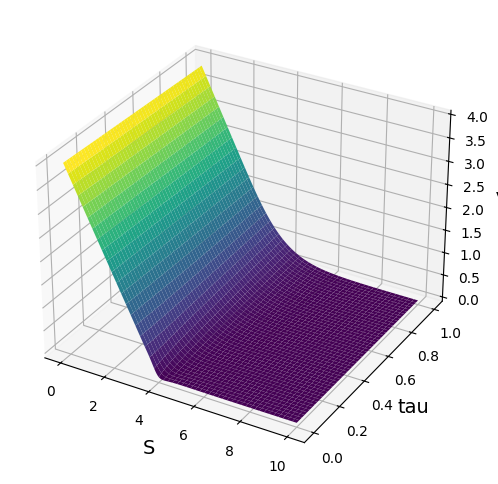

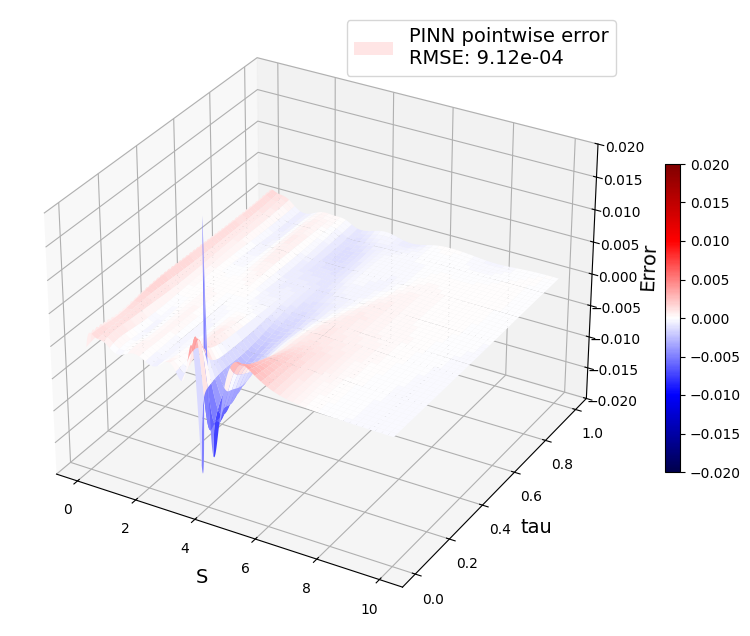

In [87]:
model = torch.load(f'models/{model_name}.pt').to('cpu')

S_eval = torch.linspace(0, 10, 1000)
tau_eval = torch.linspace(0, T, 1000)
S_eval, tau_eval = torch.meshgrid(S_eval, tau_eval)  # torch meshgrid uses different indexing
V_pred = model(S_eval.reshape(-1, 1), tau_eval.reshape(-1, 1)).detach().numpy().reshape(1000, 1000).T

# compute error metrics
S_eval = np.linspace(0, 10, 1000)
tau_eval = np.linspace(0, T, 1000)
S_eval, tau_eval = np.meshgrid(S_eval, tau_eval)
V_true = V_BS(S_eval, tau_eval, K, r, sigma, 'put')
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_surface(S_eval, tau_eval, V_true, cmap='viridis')
V_err = V_pred - V_true
MSE = np.mean(V_err**2)
RMSE = np.sqrt(MSE)
print('MSE:', MSE)
print('RMSE:', RMSE)
print(V_err.min(), V_err.max())

# 3d plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S_eval, tau_eval, V_pred, cmap='viridis')
ax.set_xlabel('S', fontsize=14)
ax.set_ylabel('tau', fontsize=14)
ax.set_zlabel('V', fontsize=14)
# ax.set_title('PINN Solution', fontsize=16)
plt.savefig('./data/images/sol_european_3d.pdf')
plt.show()

# plot error surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S_eval, tau_eval, V_err, label=f'PINN pointwise error\nRMSE: {RMSE:.2e}', cmap='seismic', vmin=-0.02, vmax=0.02)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
ax.set_zlim(-0.02, 0.02)
ax.set_xlabel('S', fontsize=14)
ax.set_ylabel('tau', fontsize=14)
ax.set_zlabel('Error', fontsize=14)
# ax.set_title('PINN Pointwise Error', fontsize=16)
plt.legend(fontsize=14)
plt.savefig('./data/images/sol_european_3d_err.pdf')
plt.show()

MSE: 1.0228945588586231e-07
RMSE: 0.0003198272281808763
-0.0010429283759545438 0.025331998665331902


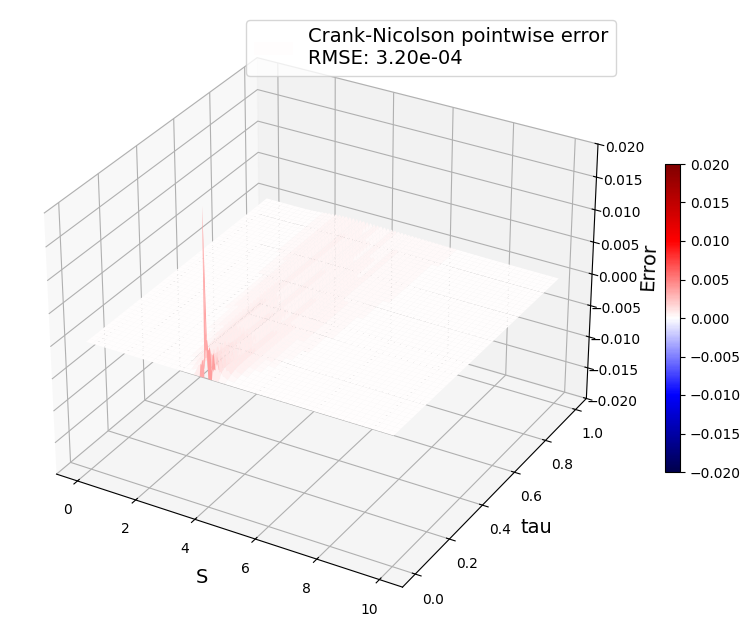

In [88]:
from scipy.interpolate import RegularGridInterpolator

# Crank-Nicolson solution
V_CN, S_CN, t_CN = V_BS_CN(100, 100, T, K, sigma, r, S_inf)
V_CN = V_CN.T

# interpolate CN solution on eval grid
interpolator = RegularGridInterpolator((S_CN, t_CN), V_CN, method='linear', bounds_error=False, fill_value=np.nan)
S_eval = np.linspace(0, 10, 1000)
tau_eval = np.linspace(0, T, 1000)
S_eval, tau_eval = np.meshgrid(S_eval, tau_eval)
V_pred_CN = interpolator((S_eval, tau_eval))

# compute error metrics
V_true = V_BS(S_eval, tau_eval, K, r, sigma, 'put')
V_err_CN = V_pred_CN - V_true
MSE_CN = np.mean(V_err_CN**2)
RMSE_CN = np.sqrt(MSE_CN)
print('MSE:', MSE_CN)
print('RMSE:', RMSE_CN)
print(V_err_CN.min(), V_err_CN.max())

# 3d plot CN solution
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(S_eval, tau_eval, V_pred_CN, cmap='viridis')
# ax.set_xlabel('S', fontsize=14)
# ax.set_ylabel('tau', fontsize=14)
# ax.set_zlabel('V', fontsize=14)
# ax.set_title('Crank-Nicolson Solution', fontsize=16)
# # plt.savefig('./data/images/sol_european_cn.pdf')
# plt.show()


# plot error surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S_eval, tau_eval, V_err_CN, label=f'Crank-Nicolson pointwise error\nRMSE: {RMSE_CN:.2e}', cmap='seismic', vmin=-0.02, vmax=0.02)
cbar = fig.colorbar(surf, location='right', shrink=0.5)
ax.set_xlabel('S', fontsize=14)
ax.set_ylabel('tau', fontsize=14)
ax.set_zlabel('Error', fontsize=14)
ax.set_zlim(-0.02, 0.02)
plt.legend(fontsize=14)
plt.savefig('./data/images/sol_european_cn_err.pdf')
plt.show()

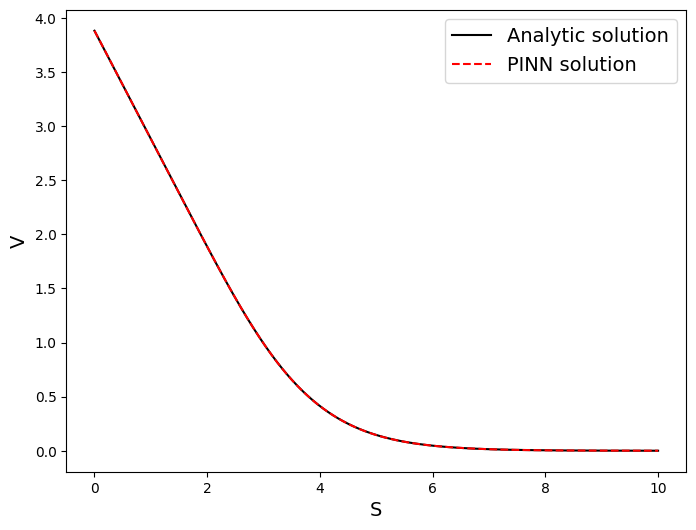

In [94]:
# plot tau = T
plt.figure(figsize=(8, 6))
plt.plot(S_eval[-1], V_true[-1], label='Analytic solution', c='k')
plt.plot(S_eval[-1], V_pred[-1], '--r', label='PINN solution')
# plt.plot(S_eval[-1], V_pred_CN[-1], ':b')
plt.xlabel('S', fontsize=14)
plt.ylabel('V', fontsize=14)
plt.legend(fontsize=14)
plt.savefig('./data/images/sol_european_2d.pdf')
plt.show()

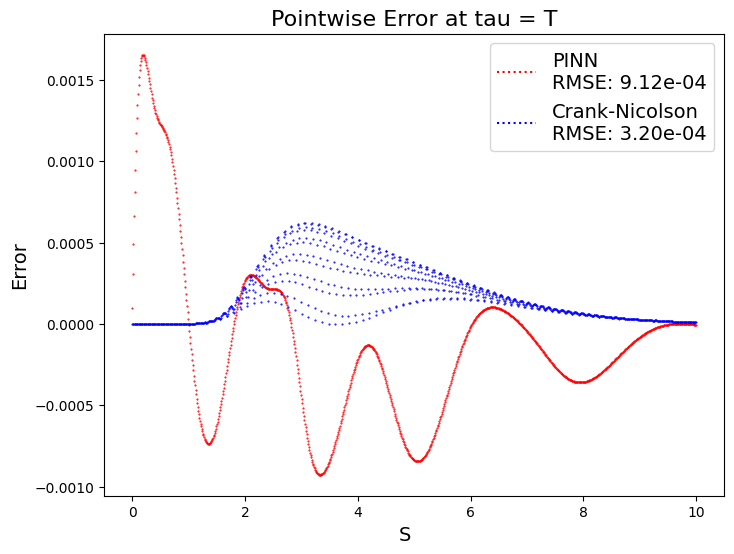

In [96]:
# plot pointwise error at tau = T
plt.figure(figsize=(8, 6))
plt.plot(S_eval[-1], V_err[-1], '.', c='r', ms=1)
plt.plot(S_eval[-1], V_err_CN[-1], '.', c='b', ms=1)
plt.plot([], [], ':r', label=f'PINN\nRMSE: {RMSE:.2e}')
plt.plot([], [], ':b', label=f'Crank-Nicolson\nRMSE: {RMSE_CN:.2e}')
plt.xlabel('S   ', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Pointwise Error at tau = T', fontsize=16)
plt.legend(fontsize=14)
plt.savefig('./data/images/sol_european_2d_err.pdf')
plt.show()

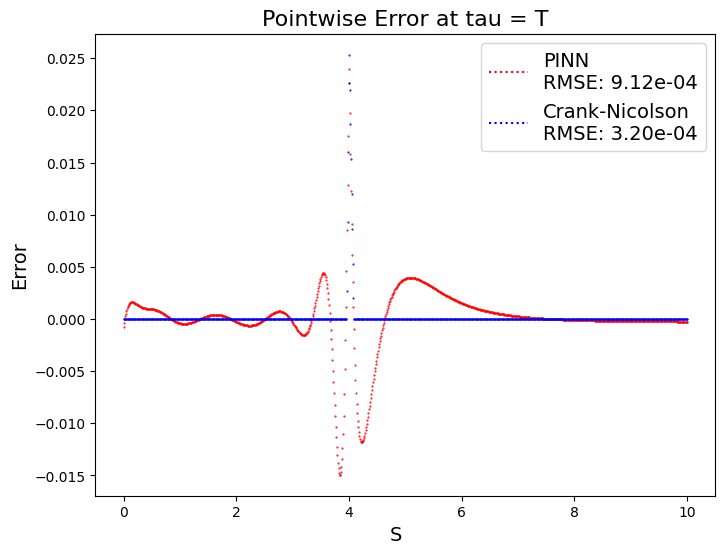

In [97]:
# plot pointwise error at tau = 0
plt.figure(figsize=(8, 6))
plt.plot(S_eval[-1], V_err[0], '.', c='r', ms=1)
plt.plot(S_eval[-1], V_err_CN[0], '.', c='b', ms=1)
plt.plot([], [], ':r', label=f'PINN\nRMSE: {RMSE:.2e}')
plt.plot([], [], ':b', label=f'Crank-Nicolson\nRMSE: {RMSE_CN:.2e}')
plt.xlabel('S   ', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title('Pointwise Error at tau = T', fontsize=16)
plt.legend(fontsize=14)
plt.savefig('./data/images/sol_european_2d_err.pdf')
plt.show()